# Visualizing Data by Segment of Footprint

In [1]:
import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [2]:
import os
import sys
import h5py
import laspy
import pyproj
import datetime 
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from shapely.geometry import Polygon
from sklearn.neighbors import NearestNeighbors

plt.style.use("~/geoscience/carbon_estimation/MNRAS.mplstyle")
%matplotlib inline

# SciPy for exact p-values / critical t
try:
    from scipy import stats
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

In [3]:
function_path = os.path.expanduser("~/geoscience/carbon_estimation/code/functions")
sys.path.append(function_path)

# Check the default PROJ data directory
print(pyproj.datadir.get_data_dir())

/bsuscratch/tnde/miniforge3/envs/veg_height/share/proj


## Loading ICESat2 Data

In [4]:
from helper_functions import load_icesat2_data
projected_crs = "epsg:6340" 
icesat2_file = "icesat2_ml2.geojson"
icesat2_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/"
atl08 = icesat2_dir+f'{icesat2_file}'
atl08

'/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/icesat2_ml2.geojson'

In [5]:
%%time
icesat2_gdf_atl08 = load_icesat2_data(atl08, "ATL08", process = False)
icesat2_gdf_atl08 = icesat2_gdf_atl08[icesat2_gdf_atl08["gnd_ph_count"] != 0]
icesat2_gdf_atl08 = icesat2_gdf_atl08[icesat2_gdf_atl08["h_mean_canopy"] <= 15]
icesat2_gdf_atl08_ground = icesat2_gdf_atl08.rename(columns={"elevation_NAVD88_icesat2_from_crs": "Elevation"})
icesat2_gdf_atl08_non_ground = icesat2_gdf_atl08_ground.copy()
icesat2_gdf_atl08_non_ground["Elevation"] = icesat2_gdf_atl08_non_ground["Elevation"]+icesat2_gdf_atl08_non_ground["h_mean_canopy"]
icesat2_gdf_atl08_non_ground = icesat2_gdf_atl08_non_ground[icesat2_gdf_atl08_non_ground["h_mean_canopy"]>0]
print(f"Length of data: {len(icesat2_gdf_atl08)}")
print(icesat2_gdf_atl08.crs, "\n")
icesat2_gdf_atl08.crs

ERROR 1: PROJ: proj_create_from_database: Open of /bsuscratch/tnde/miniforge3/envs/veg_height/share/proj failed


Length of data: 32815
EPSG:6340 

CPU times: user 2.68 s, sys: 61.2 ms, total: 2.75 s
Wall time: 2.76 s


<Projected CRS: EPSG:6340>
Name: NAD83(2011) / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - between 120°W and 114°W onshore and offshore - California, Idaho, Nevada, Oregon, Washington.
- bounds: (-120.0, 30.88, -114.0, 49.01)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
# icesat2_dir_ground = "/bsuhome/tnde/scratch/carbon_estimation/cloudcompare/rcew_icesat2_atl08_all_xyz_ground.csv"
# icesat2_dir_non_ground = "/bsuhome/tnde/scratch/carbon_estimation/cloudcompare/rcew_icesat2_atl08_all_xyz_non_ground_only.csv"
# icesat2_gdf_atl08_ground = pd.read_csv(icesat2_dir_ground)
# icesat2_gdf_atl08_non_ground = pd.read_csv(icesat2_dir_non_ground)

# icesat2_gdf_atl08_ground = icesat2_gdf_atl08_ground.rename(columns={"X": "Easting", "Y": "Northing", "Z": "Elevation"})
# icesat2_gdf_atl08_non_ground = icesat2_gdf_atl08_ground.rename(columns={"X": "Easting", "Y": "Northing", "Z_non_ground": "Elevation"})

# icesat2_gdf_atl08_ground = icesat2_gdf_atl08_ground[icesat2_gdf_atl08_ground["h_mean_canopy"] <= 15]
# icesat2_gdf_atl08_non_ground = icesat2_gdf_atl08_non_ground[icesat2_gdf_atl08_non_ground["h_mean_canopy"] <= 15]

## Loading GEDI Data

In [7]:
drop_cols = ["shot_number", "Latitude_l2a", "Longitude_l2a", 
             "rh_85", "rh_90", "rh_98", "rh_99", "GEDI02_A_slope_ratio_utm", 
             "GEDI02_A_slope_rise_run", "cover_z_10", "cover_z_15", "cover_z_20", 
             "cover_z_25", "cover_z_27", "cover_z_28", "pai_z_10", "pai_z_15", 
             "pai_z_20", "pai_z_25", "pai_z_27", "pai_z_28", "pavd_z_10", 
             "pavd_z_15", "pavd_z_20", "pavd_z_25", "pavd_z_27", "pavd_z_28", "rh100", "geometry"]

In [8]:
target_col = "rh_100" # "rh_80"
gedi_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/"
gedi_file = "gedi_ml2.geojson"
gedi_data = gpd.read_file(os.path.join(gedi_dir, gedi_file))
gedi_data = gedi_data.drop(drop_cols, axis = 1)
gedi_data = gedi_data[gedi_data["fhd_normal"] != -9999.000000]
gedi_data = gedi_data[gedi_data[target_col] <= 20]
gedi_data_ground = gedi_data.rename(columns={"Easting_l2a": "Easting", "Northing_l2a": "Northing", "BEAM_l2a": "BEAM", "elevation_NAVD88_gedi_from_crs_l2a": "Elevation"})
gedi_data_non_ground = gedi_data_ground.copy()
gedi_data_non_ground["Elevation"] = gedi_data_non_ground["Elevation"]+gedi_data_non_ground["rh_100"]
gedi_data_non_ground = gedi_data_non_ground[gedi_data_non_ground["rh_100"]>0]

In [9]:
# gedi_dir_ground = "/bsuhome/tnde/scratch/carbon_estimation/cloudcompare/gedi_xyz_transform_l2a.csv"
# gedi_dir_non_ground = "/bsuhome/tnde/scratch/carbon_estimation/cloudcompare/gedi_xyz_transform_l2a_non_ground_only_final.csv"

# gedi_data_ground = pd.read_csv(gedi_dir_ground)
# gedi_data_non_ground = pd.read_csv(gedi_dir_non_ground)

# gedi_data_ground = gedi_data_ground.rename(columns={"elevation_NAVD88_gedi_from_crs": "Elevation"})
# gedi_data_non_ground = gedi_data_non_ground.rename(columns={"Easting_l2a": "Easting", "Northing_l2a": "Northing", "elevation_non_ground": "Elevation"})

# # gedi_data_ground = gedi_data_ground[gedi_data_ground["rh_100"] <= 15]
# # gedi_data_non_ground = gedi_data_non_ground[gedi_data_non_ground["rh_100"] <= 15]

## Nearest Neighbour Data Points, T-Test, and Plotting Functions.

In [10]:
def _nearest_pairs(df1, dfX, xcol="Easting", ycol="Northing", max_dist=None):
    """
    Nearest-neighbor join: for each point in dfX, find the closest point in df1.
    Returns a DataFrame where each row is a matched pair with suffixes _df1 and _dfX.
    If max_dist (same units as coords) is given, pairs farther than this are dropped.
    """
    if dfX.empty or df1.empty:
        return pd.DataFrame()

    nbrs = NearestNeighbors(n_neighbors=1, algorithm="kd_tree")
    nbrs.fit(df1[[xcol, ycol]].to_numpy())

    distances, indices = nbrs.kneighbors(dfX[[xcol, ycol]].to_numpy(), return_distance=True)
    distances = distances.ravel()
    indices = indices.ravel()

    keep = np.ones_like(distances, dtype=bool)
    if max_dist is not None:
        keep = distances <= max_dist
    if not keep.any():
        return pd.DataFrame()

    left = df1.iloc[indices[keep]].reset_index(drop=True).add_suffix("_df1")
    right = dfX.iloc[np.where(keep)[0]].reset_index(drop=True).add_suffix("_dfX")
    out = pd.concat([left, right], axis=1)
    out["nn_distance"] = distances[keep]
    return out


def _ind_ttest_from_pairs(pairs, elev_col="Elevation", label="df1 vs dfX", equal_var=False):
    """
    Runs an INDEPENDENT two-sample t-test on elevation using the matched subset,
    treating the two samples as independent (not paired).
      - Welch's t-test by default (equal_var=False).
      - If SciPy is not available, prints t-stat and dof; p/CI = NaN.

    Uses columns: {elev_col}_df1 and {elev_col}_dfX from `pairs`.
    """
    c1 = f"{elev_col}_df1"
    cX = f"{elev_col}_dfX"
    if c1 not in pairs or cX not in pairs:
        print(f"[{label}] Missing columns '{c1}' / '{cX}'. Set elev_col correctly.")
        return

    a = pairs[c1].to_numpy(dtype=float)
    b = pairs[cX].to_numpy(dtype=float)
    mask = np.isfinite(a) & np.isfinite(b)
    a, b = a[mask], b[mask]
    n1, n2 = len(a), len(b)
    if n1 < 2 or n2 < 2:
        print(f"[{label}] Not enough data for independent t-test (n1={n1}, n2={n2}).")
        return

    mean1, mean2 = a.mean(), b.mean()
    var1, var2 = a.var(ddof=1), b.var(ddof=1)
    diff = mean1 - mean2

    if _HAS_SCIPY:
        t_stat, p_val = stats.ttest_ind(a, b, equal_var=equal_var, nan_policy="omit")
        if equal_var:
            dof = n1 + n2 - 2
            sp2 = ((n1 - 1) * var1 + (n2 - 1) * var2) / dof
            se = np.sqrt(sp2 * (1/n1 + 1/n2))
        else:
            se = np.sqrt(var1 / n1 + var2 / n2)
            dof_num = (var1 / n1 + var2 / n2) ** 2
            dof_den = (var1**2 / (n1**2 * (n1 - 1))) + (var2**2 / (n2**2 * (n2 - 1)))
            dof = dof_num / dof_den
        tcrit = stats.t.ppf(0.975, dof)
        ci_lo, ci_hi = diff - tcrit * se, diff + tcrit * se
    else:
        # Manual Welch or pooled t (without p-values / CI)
        if equal_var:
            dof = n1 + n2 - 2
            sp2 = ((n1 - 1) * var1 + (n2 - 1) * var2) / dof
            se = np.sqrt(sp2 * (1/n1 + 1/n2))
        else:
            se = np.sqrt(var1 / n1 + var2 / n2)
            dof_num = (var1 / n1 + var2 / n2) ** 2
            dof_den = (var1**2 / (n1**2 * (n1 - 1))) + (var2**2 / (n2**2 * (n2 - 1)))
            dof = dof_num / dof_den
        t_stat = diff / se if se > 0 else np.nan
        p_val = np.nan
        ci_lo = ci_hi = np.nan

    method = "Student (equal variances)" if equal_var else "Welch (unequal variances)"
    print(f"\nIndependent t-test [{label}] on '{elev_col}' — {method}")
    print(f"  n1 = {n1}, n2 = {n2}, dof = {dof:.4g}")
    print(f"  mean(df1) = {mean1:.6g}, mean(dfX) = {mean2:.6g}")
    print(f"  difference (df1 - dfX) = {diff:.6g}")
    print(f"  t = {t_stat:.6g}, p = {p_val:.6g}")
    print(f"  95% CI (diff): [{ci_lo:.6g}, {ci_hi:.6g}]")

def pair_and_plot_indttest(
    df1, df2, df3,
    xcol="Easting", ycol="Northing", elev_col="Elevation",
    max_dist=None, plot=True, connect_pairs=True, equal_var=False, 
    bbox = None # provide bbox as a list in the format [minx, miny, maxx, maxy]
):
    """
    1) Compute df1 bounding box.
    2) Filter df2/df3 to that box.
    3) Build nearest pairs (df1 <--> df2) and (df1 <--> df3).
    4) Run INDEPENDENT two-sample t-tests on 'elev_col' for both sets and print results.
    5) Plot ONLY the paired points within the bbox (optionally draw connectors).

    Returns: pairs12, pairs13
    """
    if bbox is not None:
        x_min, y_min, x_max, y_max = bbox
    else:
        # Bounding box from df1
        x_min, x_max = df1[xcol].min(), df1[xcol].max()
        y_min, y_max = df1[ycol].min(), df1[ycol].max()

    # Filter df2/df3 to bbox
    df2_f = df2[(df2[xcol] >= x_min) & (df2[xcol] <= x_max) &
                (df2[ycol] >= y_min) & (df2[ycol] <= y_max)].copy()
    df3_f = df3[(df3[xcol] >= x_min) & (df3[xcol] <= x_max) &
                (df3[ycol] >= y_min) & (df3[ycol] <= y_max)].copy()

    # Nearest pairs
    pairs12 = _nearest_pairs(df1, df2_f, xcol=xcol, ycol=ycol, max_dist=max_dist)
    pairs13 = _nearest_pairs(df1, df3_f, xcol=xcol, ycol=ycol, max_dist=max_dist)

    # Independent t-tests (Welch by default)
    if not pairs12.empty:
        _ind_ttest_from_pairs(pairs12, elev_col=elev_col, label="df1 vs df2", equal_var=equal_var)
    else:
        print("\nNo paired points found for df1 vs df2 inside the bounding box (or after max_dist filtering).")

    if not pairs13.empty:
        _ind_ttest_from_pairs(pairs13, elev_col=elev_col, label="df1 vs df3", equal_var=equal_var)
    else:
        print("No paired points found for df1 vs df3 inside the bounding box (or after max_dist filtering).")

    # Plot: ONLY the paired points (within bbox)
    if plot:
        plt.figure(figsize=(10, 6))

        # df1 (paired only)
        xs1 = pd.concat([
            pairs12.get(f"{xcol}_df1", pd.Series([], dtype=float)),
            pairs13.get(f"{xcol}_df1", pd.Series([], dtype=float)),
        ], ignore_index=True)
        ys1 = pd.concat([
            pairs12.get(f"{ycol}_df1", pd.Series([], dtype=float)),
            pairs13.get(f"{ycol}_df1", pd.Series([], dtype=float)),
        ], ignore_index=True)
        if len(xs1) > 0:
            plt.scatter(xs1, ys1, s=15, alpha=1.0, color="red", marker="s", label="LiDAR (paired only)")

        # df2 paired
        if not pairs12.empty:
            plt.scatter(pairs12[f"{xcol}_dfX"], pairs12[f"{ycol}_dfX"], s=5, alpha=0.9, color="black", label="ICESat-2 (paired)")

        # df3 paired
        if not pairs13.empty:
            plt.scatter(pairs13[f"{xcol}_dfX"], pairs13[f"{ycol}_dfX"], s=5, alpha=0.9, color="blue", label="GEDI (paired)")

        # connectors
        if connect_pairs and not pairs12.empty:
            for i in range(len(pairs12)):
                plt.plot(
                    [pairs12[f"{xcol}_df1"].iat[i], pairs12[f"{xcol}_dfX"].iat[i]],
                    [pairs12[f"{ycol}_df1"].iat[i], pairs12[f"{ycol}_dfX"].iat[i]],
                    linewidth=0.6, alpha=0.25, color="magenta"
                )
        if connect_pairs and not pairs13.empty:
            for i in range(len(pairs13)):
                plt.plot(
                    [pairs13[f"{xcol}_df1"].iat[i], pairs13[f"{xcol}_dfX"].iat[i]],
                    [pairs13[f"{ycol}_df1"].iat[i], pairs13[f"{ycol}_dfX"].iat[i]],
                    linewidth=0.6, alpha=0.25, color="magenta"
                )

        # Bounding box outline (for context)
        plt.plot([x_min, x_max, x_max, x_min, x_min],
                 [y_min, y_min, y_max, y_max, y_min],
                 linestyle="--", color="black", 
                 label="Bounding box")

        plt.xlabel(xcol)
        plt.ylabel(ycol)
        plt.title("Paired points only (within df1 bounding box)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return pairs12, pairs13

# max_dist = 5
max_dist = None
equal_var = True

## Flat Tile, Has Vegetation

### Ground Truth Data

In [11]:
%%time
# Specify the path to .laz file
laz_file_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/test_laz/USGS_LPC_ID_SouthernID_2018_D19_11TNH160775.laz"

# Load the .laz file
laz_data = laspy.read(laz_file_path)

data_airbone_lidar = pd.DataFrame({
    "Easting": np.array(laz_data.x),
    "Northing": np.array(laz_data.y),
    "Elevation": np.array(laz_data.z),
    "intensity": laz_data.intensity,
    "return_number": np.array(laz_data.return_number),
    "classification": laz_data.classification,
    "user_data": laz_data.user_data,
    "point_source_id": laz_data.point_source_id,
    "gps_time": laz_data.gps_time,
    "scan_angle": laz_data.scan_angle,
    "number_of_returns": laz_data.number_of_returns
})
data_airbone_lidar = data_airbone_lidar[data_airbone_lidar["classification"].isin([1, 2, 3, 4, 5])]#.iloc[:1000000, :]
data_airbone_lidar = data_airbone_lidar[(data_airbone_lidar["scan_angle"] >= -3000) & (data_airbone_lidar["scan_angle"] <= 3000)]
data_airbone_lidar_ground = data_airbone_lidar[data_airbone_lidar["classification"] == 2]
data_airbone_lidar_non_ground = data_airbone_lidar[data_airbone_lidar["classification"] == 1]
# display(data_airbone_lidar.head())
# display(len(data_airbone_lidar))

CPU times: user 13.9 s, sys: 2.58 s, total: 16.5 s
Wall time: 9.43 s


### Independent T-Test: Ground Points


Independent t-test [df1 vs df2] on 'Elevation' — Student (equal variances)
  n1 = 296, n2 = 296, dof = 590
  mean(df1) = 1717.67, mean(dfX) = 1715.55
  difference (df1 - dfX) = 2.12012
  t = 0.515677, p = 0.606273
  95% CI (diff): [-5.95449, 10.1947]

Independent t-test [df1 vs df3] on 'Elevation' — Student (equal variances)
  n1 = 91, n2 = 91, dof = 180
  mean(df1) = 1771.42, mean(dfX) = 1771.84
  difference (df1 - dfX) = -0.424292
  t = -0.103635, p = 0.917574
  95% CI (diff): [-8.50288, 7.6543]


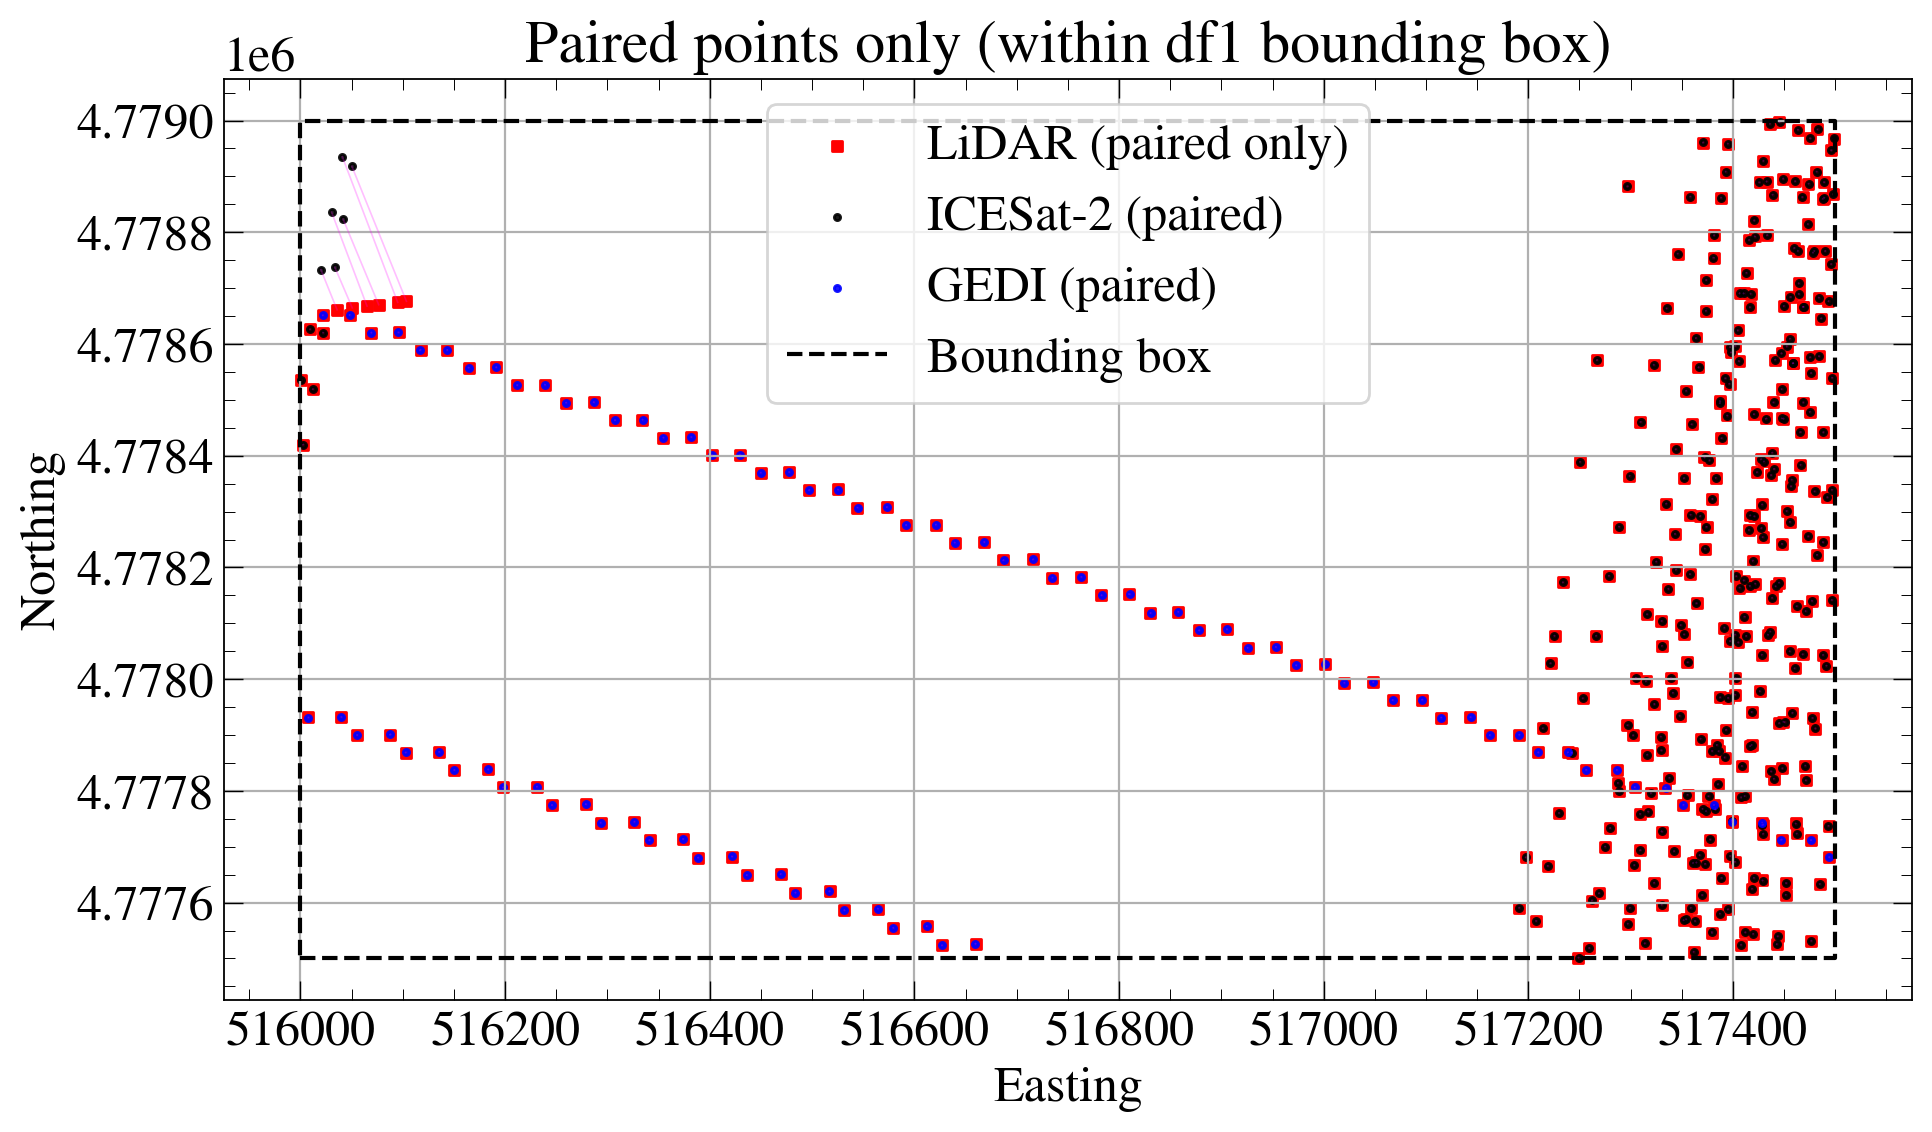

In [12]:
pairs_icesat2, pairs_gedi = pair_and_plot_indttest(
    data_airbone_lidar_ground, icesat2_gdf_atl08_ground, gedi_data_ground,
    xcol="Easting", ycol="Northing", elev_col="Elevation",
    max_dist=max_dist, plot=True, connect_pairs=True,
    equal_var=equal_var   # Welch by default; set True for Student's pooled t-test
)


### Independent T-Test: Non-Ground Points

In [13]:
pairs_icesat2, pairs_gedi = pair_and_plot_indttest(
    data_airbone_lidar_non_ground, icesat2_gdf_atl08_non_ground, gedi_data_non_ground,
    xcol="Easting", ycol="Northing", elev_col="Elevation",
    max_dist=max_dist, plot=False, connect_pairs=True,
    equal_var=equal_var   # Welch by default; set True for Student's pooled t-test
)



Independent t-test [df1 vs df2] on 'Elevation' — Student (equal variances)
  n1 = 286, n2 = 286, dof = 570
  mean(df1) = 1717.47, mean(dfX) = 1718.38
  difference (df1 - dfX) = -0.916577
  t = -0.218928, p = 0.826784
  95% CI (diff): [-9.13972, 7.30657]

Independent t-test [df1 vs df3] on 'Elevation' — Student (equal variances)
  n1 = 91, n2 = 91, dof = 180
  mean(df1) = 1772.27, mean(dfX) = 1777.22
  difference (df1 - dfX) = -4.95231
  t = -1.18514, p = 0.237524
  95% CI (diff): [-13.1978, 3.29317]


## Not Flat Tile, Has No Vegetation

### Ground Truth Data

In [14]:
%%time
# Specify the path to .laz file
laz_file_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/test_laz/USGS_LPC_ID_SouthernID_2018_D19_11TNH190760.laz"

# Load the .laz file
laz_data = laspy.read(laz_file_path)

data_airbone_lidar = pd.DataFrame({
    "Easting": np.array(laz_data.x),
    "Northing": np.array(laz_data.y),
    "Elevation": np.array(laz_data.z),
    "intensity": laz_data.intensity,
    "return_number": np.array(laz_data.return_number),
    "classification": laz_data.classification,
    "user_data": laz_data.user_data,
    "point_source_id": laz_data.point_source_id,
    "gps_time": laz_data.gps_time,
    "scan_angle": laz_data.scan_angle,
    "number_of_returns": laz_data.number_of_returns
})
data_airbone_lidar = data_airbone_lidar[data_airbone_lidar["classification"].isin([1, 2, 3, 4, 5])]#.iloc[:1000000, :]
data_airbone_lidar = data_airbone_lidar[(data_airbone_lidar["scan_angle"] >= -3000) & (data_airbone_lidar["scan_angle"] <= 3000)]
data_airbone_lidar_ground = data_airbone_lidar[data_airbone_lidar["classification"] == 2]
data_airbone_lidar_non_ground = data_airbone_lidar[data_airbone_lidar["classification"] == 1]
display(data_airbone_lidar.head())
display(len(data_airbone_lidar))

,Easting,Northing,Elevation,intensity,return_number,classification,user_data,point_source_id,gps_time,scan_angle,number_of_returns
1,520254.72,4776250.89,1541.82,3840,1,1,0,3011,2.747227e+08,2833,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6,520364.84,4776272.21,1574.81,2000,1,1,0,3011,2.747227e+08,3000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
22,520401.19,4776314.18,1565.53,4048,1,2,0,3011,2.747227e+08,3000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
24,520394.54,4776300.95,1569.85,3552,1,2,0,3011,2.747227e+08,3000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
25,520288.05,4776250.91,1550.08,2352,1,1,0,3011,2.747227e+08,3000,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


17858991

CPU times: user 18.8 s, sys: 3.48 s, total: 22.3 s
Wall time: 12.9 s


### Independent T-Test: Ground Points


Independent t-test [df1 vs df2] on 'Elevation' — Student (equal variances)
  n1 = 208, n2 = 208, dof = 414
  mean(df1) = 1531.36, mean(dfX) = 1529.81
  difference (df1 - dfX) = 1.54799
  t = 0.405339, p = 0.685438
  95% CI (diff): [-5.95907, 9.05506]

Independent t-test [df1 vs df3] on 'Elevation' — Student (equal variances)
  n1 = 136, n2 = 136, dof = 270
  mean(df1) = 1465.31, mean(dfX) = 1465.9
  difference (df1 - dfX) = -0.592776
  t = -0.107796, p = 0.914237
  95% CI (diff): [-11.4192, 10.2337]


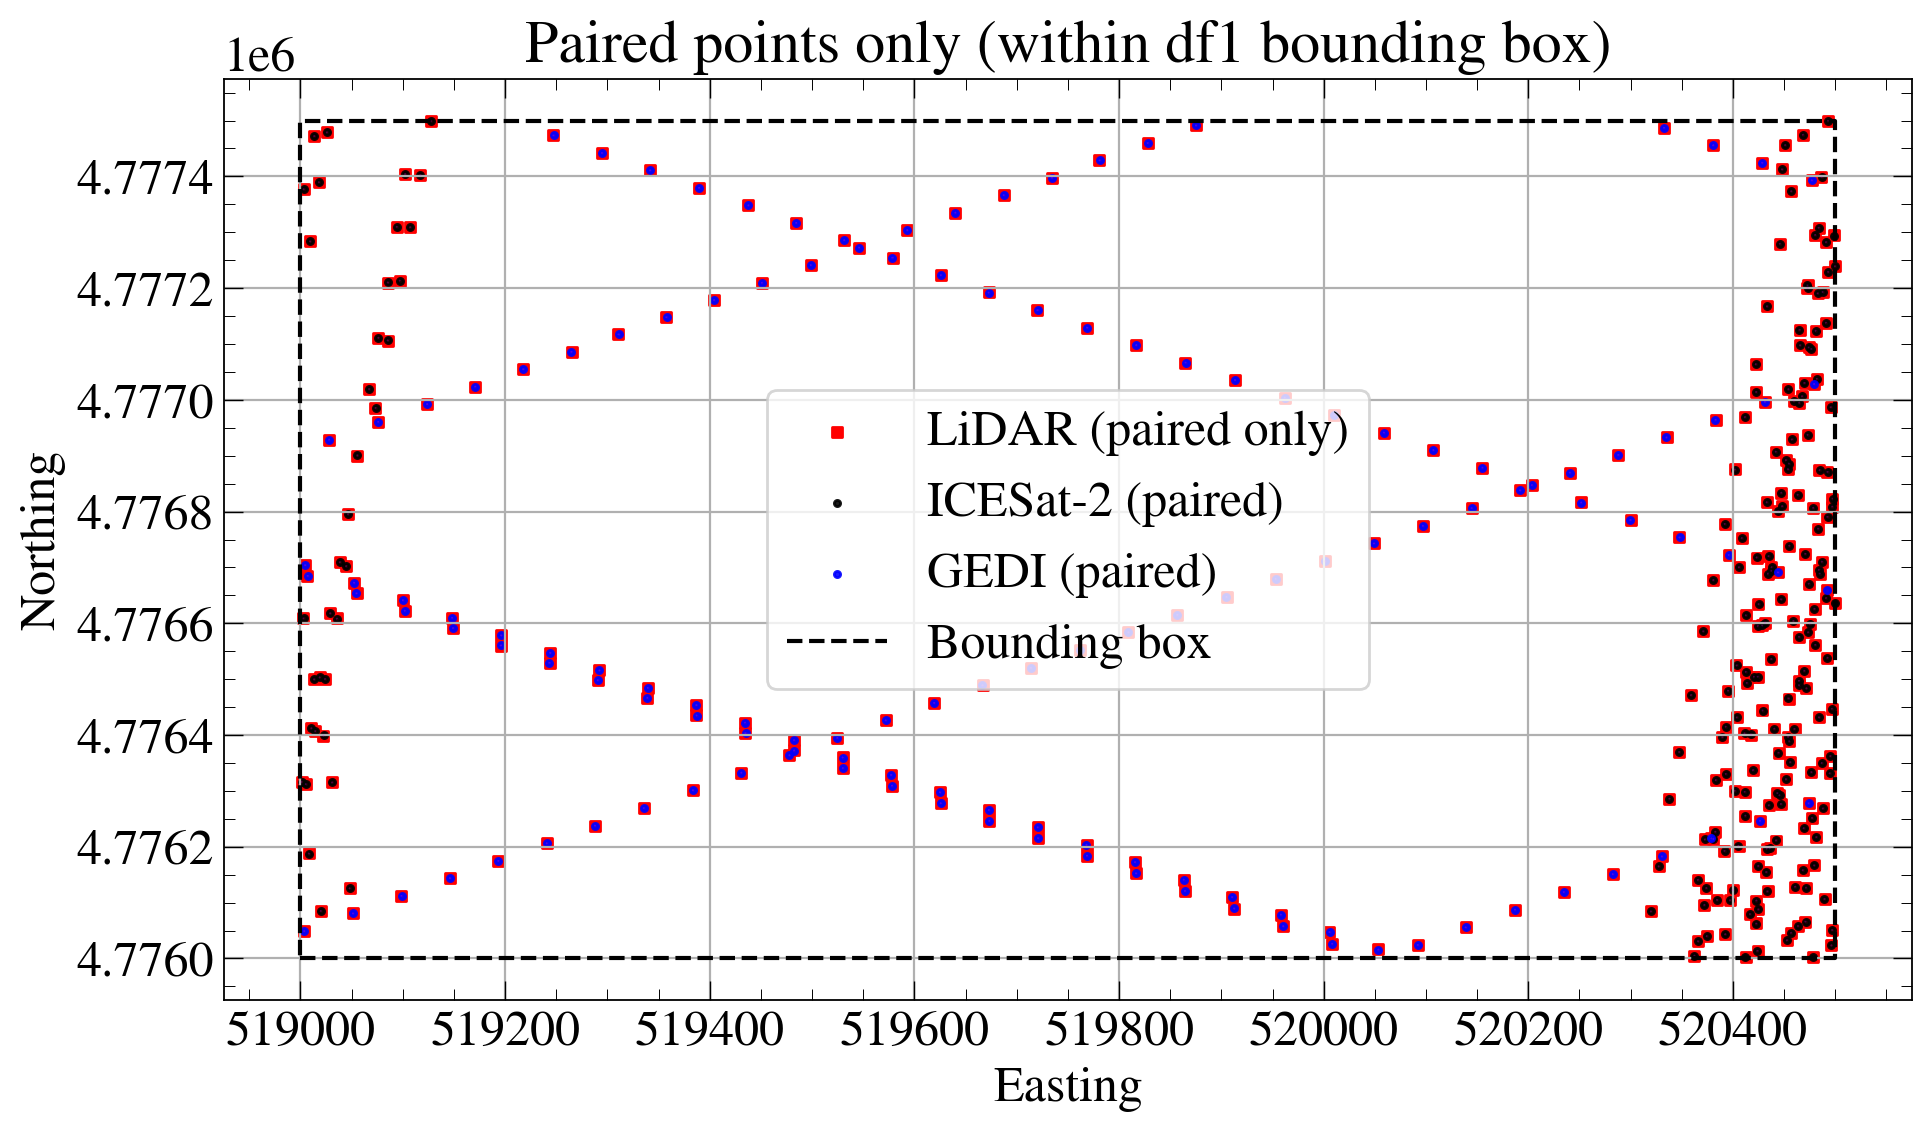

In [15]:
pairs_icesat2, pairs_gedi = pair_and_plot_indttest(
    data_airbone_lidar_ground, icesat2_gdf_atl08_ground, gedi_data_ground,
    xcol="Easting", ycol="Northing", elev_col="Elevation",
    max_dist=max_dist, plot=True, connect_pairs=True,
    equal_var=equal_var   # Welch by default; set True for Student's pooled t-test
)


### Independent T-Test: Non-Ground Points

In [16]:
pairs_icesat2, pairs_gedi = pair_and_plot_indttest(
    data_airbone_lidar_non_ground, icesat2_gdf_atl08_non_ground, gedi_data_non_ground,
    xcol="Easting", ycol="Northing", elev_col="Elevation",
    max_dist=max_dist, plot=False, connect_pairs=True,
    equal_var=equal_var   # Welch by default; set True for Student's pooled t-test
)



Independent t-test [df1 vs df2] on 'Elevation' — Student (equal variances)
  n1 = 182, n2 = 182, dof = 362
  mean(df1) = 1531.42, mean(dfX) = 1532.69
  difference (df1 - dfX) = -1.27661
  t = -0.310221, p = 0.756571
  95% CI (diff): [-9.36922, 6.816]

Independent t-test [df1 vs df3] on 'Elevation' — Student (equal variances)
  n1 = 136, n2 = 136, dof = 270
  mean(df1) = 1465.61, mean(dfX) = 1472.6
  difference (df1 - dfX) = -6.99329
  t = -1.27569, p = 0.203161
  95% CI (diff): [-17.7861, 3.79952]


## Not Flat Tile, Has Vegetation

### Ground Truth Data

In [17]:
%%time
# Specify the path to .laz file
laz_file_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/test_laz/USGS_LPC_ID_SouthernID_2018_D19_11TNH175700.laz"

# Load the .laz file
laz_data = laspy.read(laz_file_path)

data_airbone_lidar = pd.DataFrame({
    "Easting": np.array(laz_data.x),
    "Northing": np.array(laz_data.y),
    "Elevation": np.array(laz_data.z),
    "intensity": laz_data.intensity,
    "classification": laz_data.classification,
    "scan_angle": laz_data.scan_angle,
    "number_of_returns": laz_data.number_of_returns
})

CPU times: user 18.5 s, sys: 1.41 s, total: 19.9 s
Wall time: 6.97 s


In [18]:
%%time
# Specify the path to .laz file
# laz_file_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/test_laz/USGS_LPC_ID_SouthernID_2018_D19_11TNH160685.laz"
laz_file_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/test_laz/USGS_LPC_ID_SouthernID_2018_D19_11TNH175700.laz"

# Load the .laz file
laz_data = laspy.read(laz_file_path)

data_airbone_lidar = pd.DataFrame({
    "Easting": np.array(laz_data.x),
    "Northing": np.array(laz_data.y),
    "Elevation": np.array(laz_data.z),
    "intensity": laz_data.intensity,
    "return_number": np.array(laz_data.return_number),
    "classification": laz_data.classification,
    "user_data": laz_data.user_data,
    "point_source_id": laz_data.point_source_id,
    "gps_time": laz_data.gps_time,
    "scan_angle": laz_data.scan_angle,
    "number_of_returns": laz_data.number_of_returns
})
data_airbone_lidar = data_airbone_lidar[data_airbone_lidar["classification"].isin([1, 2, 3, 4, 5])]#.iloc[:1000000, :]
data_airbone_lidar = data_airbone_lidar[(data_airbone_lidar["scan_angle"] >= -3000) & (data_airbone_lidar["scan_angle"] <= 3000)]
data_airbone_lidar_ground = data_airbone_lidar[data_airbone_lidar["classification"] == 2]
data_airbone_lidar_non_ground = data_airbone_lidar[data_airbone_lidar["classification"] == 1]
display(data_airbone_lidar.head())
display(len(data_airbone_lidar))

,Easting,Northing,Elevation,intensity,return_number,classification,user_data,point_source_id,gps_time,scan_angle,number_of_returns
0,518808.30,4770000.51,1889.20,1392,1,1,0,3021,2.747243e+08,2666,"[2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ..."
1,518896.10,4770008.70,1891.70,5616,1,2,0,3021,2.747243e+08,2833,"[2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ..."
2,518814.31,4770000.47,1886.49,4160,2,1,0,3021,2.747243e+08,2666,"[2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ..."
3,518893.13,4770022.72,1890.03,5488,1,2,0,3021,2.747243e+08,2833,"[2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ..."
4,518894.76,4770012.79,1891.26,6144,1,1,0,3021,2.747243e+08,2833,"[2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ..."


22608211

CPU times: user 25.3 s, sys: 4.47 s, total: 29.8 s
Wall time: 16.7 s


### Independent T-Test: Ground Points


Independent t-test [df1 vs df2] on 'Elevation' — Student (equal variances)
  n1 = 55, n2 = 55, dof = 108
  mean(df1) = 1756.27, mean(dfX) = 1755.06
  difference (df1 - dfX) = 1.21381
  t = 0.0632667, p = 0.949671
  95% CI (diff): [-36.8155, 39.2431]

Independent t-test [df1 vs df3] on 'Elevation' — Student (equal variances)
  n1 = 15, n2 = 15, dof = 28
  mean(df1) = 1694.92, mean(dfX) = 1697.12
  difference (df1 - dfX) = -2.205
  t = -0.156255, p = 0.876953
  95% CI (diff): [-31.1113, 26.7012]


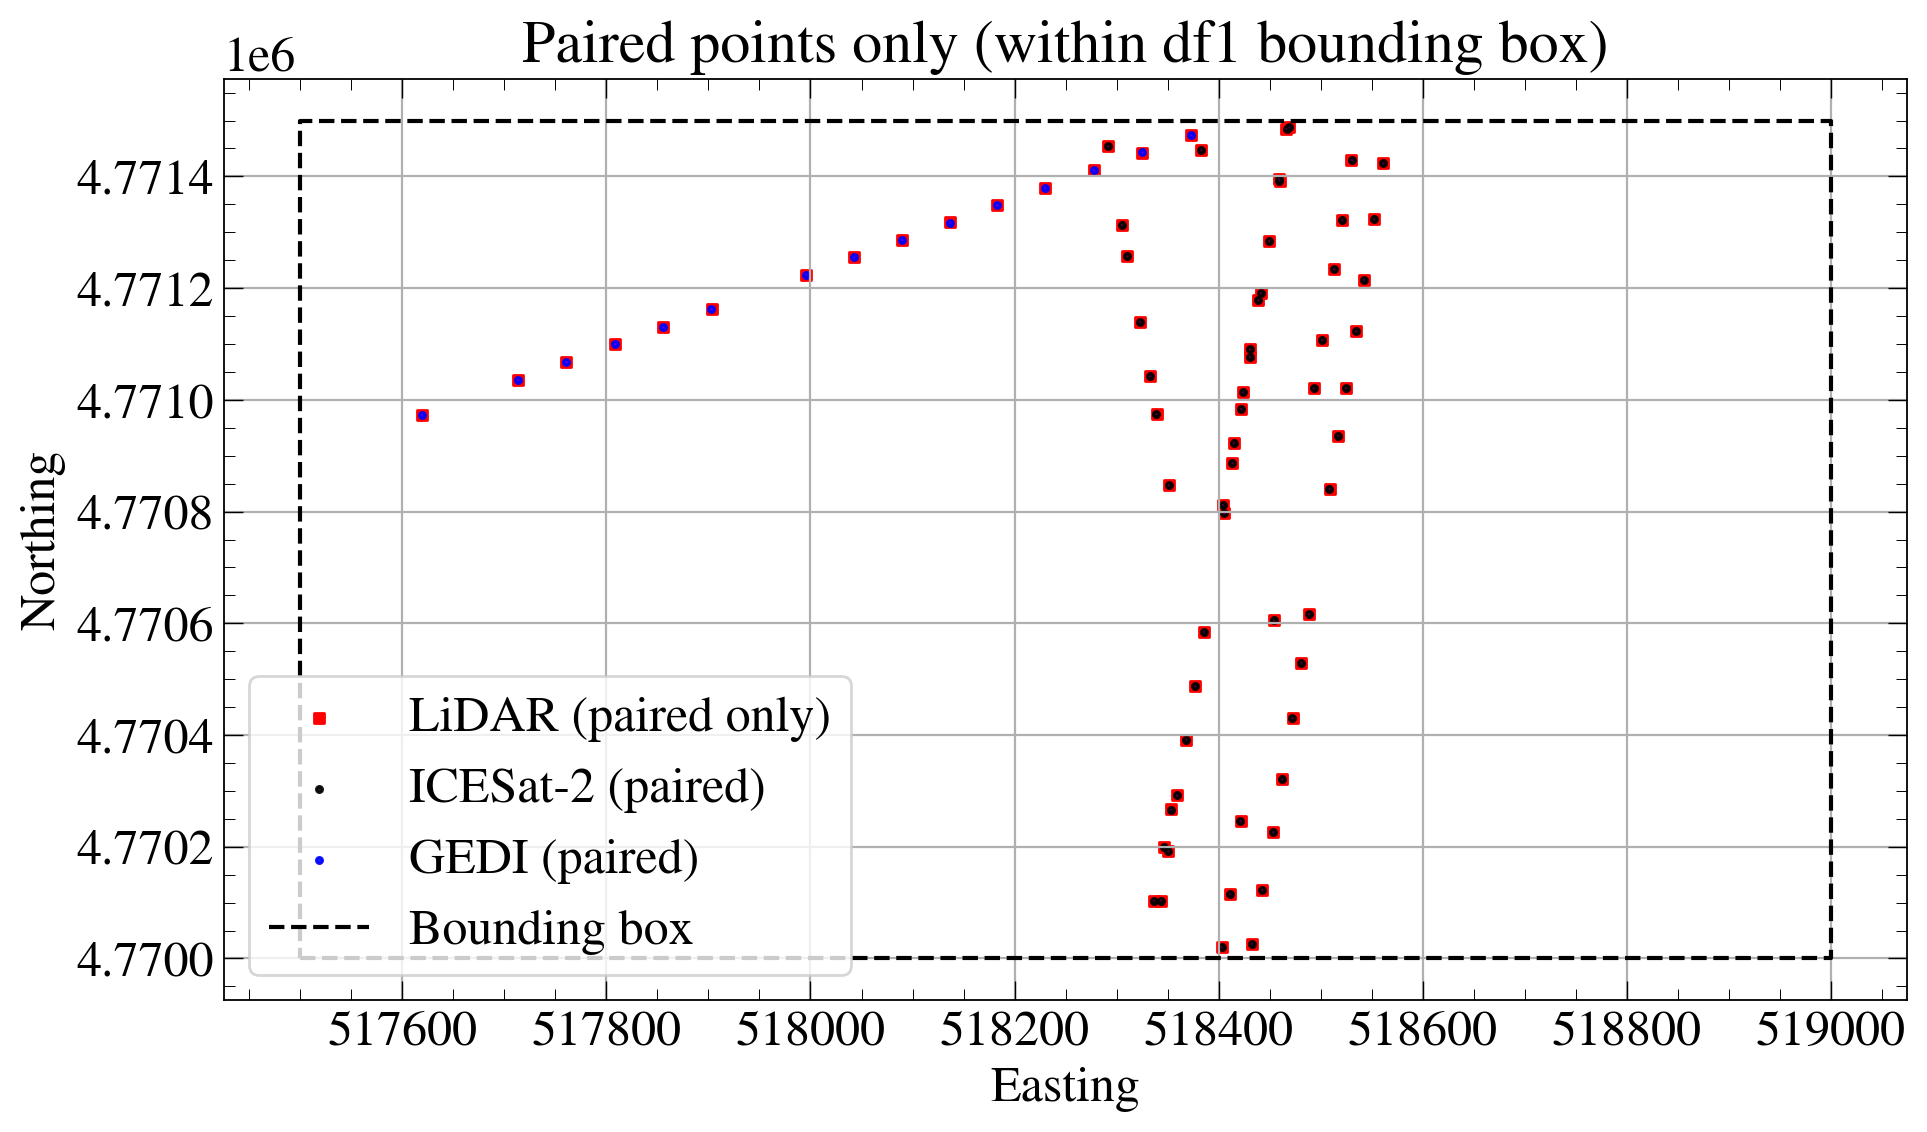

In [19]:
pairs_icesat2, pairs_gedi = pair_and_plot_indttest(
    data_airbone_lidar_ground, icesat2_gdf_atl08_ground, gedi_data_ground,
    xcol="Easting", ycol="Northing", elev_col="Elevation",
    max_dist=max_dist, plot=True, connect_pairs=True,
    equal_var=equal_var   # Welch by default; set True for Student's pooled t-test
)


### Independent T-Test: Non-Ground Points

In [20]:
pairs_icesat2, pairs_gedi = pair_and_plot_indttest(
    data_airbone_lidar_non_ground, icesat2_gdf_atl08_non_ground, gedi_data_non_ground,
    xcol="Easting", ycol="Northing", elev_col="Elevation",
    max_dist=max_dist, plot=False, connect_pairs=True,
    equal_var=equal_var   # Welch by default; set True for Student's pooled t-test
)


Independent t-test [df1 vs df2] on 'Elevation' — Student (equal variances)
  n1 = 48, n2 = 48, dof = 94
  mean(df1) = 1767.59, mean(dfX) = 1769.75
  difference (df1 - dfX) = -2.15495
  t = -0.102877, p = 0.91828
  95% CI (diff): [-43.7454, 39.4355]

Independent t-test [df1 vs df3] on 'Elevation' — Student (equal variances)
  n1 = 15, n2 = 15, dof = 28
  mean(df1) = 1696.91, mean(dfX) = 1709.52
  difference (df1 - dfX) = -12.6083
  t = -0.882, p = 0.385286
  95% CI (diff): [-41.8907, 16.674]


## Flat Tile, Has No Vegetation

### Ground Truth Data

In [21]:
%%time
# Specify the path to .laz file
laz_file_path = "/bsuhome/tnde/scratch/carbon_estimation/airborne_lidar/test_laz/USGS_LPC_ID_SouthernID_2018_D19_11TNH190820.laz"

# Load the .laz file
laz_data = laspy.read(laz_file_path)

data_airbone_lidar = pd.DataFrame({
    "Easting": np.array(laz_data.x),
    "Northing": np.array(laz_data.y),
    "Elevation": np.array(laz_data.z),
    "intensity": laz_data.intensity,
    "return_number": np.array(laz_data.return_number),
    "classification": laz_data.classification,
    "user_data": laz_data.user_data,
    "point_source_id": laz_data.point_source_id,
    "gps_time": laz_data.gps_time,
    "scan_angle": laz_data.scan_angle,
    "number_of_returns": laz_data.number_of_returns
})

data_airbone_lidar = data_airbone_lidar[data_airbone_lidar["classification"].isin([1, 2, 3, 4, 5])]#.iloc[:1000000, :]
data_airbone_lidar = data_airbone_lidar[(data_airbone_lidar["scan_angle"] >= -3000) & (data_airbone_lidar["scan_angle"] <= 3000)]
data_airbone_lidar_ground = data_airbone_lidar[data_airbone_lidar["classification"] == 2]
data_airbone_lidar_non_ground = data_airbone_lidar[data_airbone_lidar["classification"] == 1]
# display(data_airbone_lidar.head())
# display(len(data_airbone_lidar))

CPU times: user 8.95 s, sys: 1.63 s, total: 10.6 s
Wall time: 6.2 s


### Independent T-Test: Ground Points


Independent t-test [df1 vs df2] on 'Elevation' — Student (equal variances)
  n1 = 89, n2 = 89, dof = 176
  mean(df1) = 1216.03, mean(dfX) = 1215.99
  difference (df1 - dfX) = 0.0398015
  t = 0.0259423, p = 0.979333
  95% CI (diff): [-2.98806, 3.06767]

Independent t-test [df1 vs df3] on 'Elevation' — Student (equal variances)
  n1 = 59, n2 = 59, dof = 116
  mean(df1) = 1221.03, mean(dfX) = 1220.98
  difference (df1 - dfX) = 0.0437961
  t = 0.0206514, p = 0.983559
  95% CI (diff): [-4.15657, 4.24416]


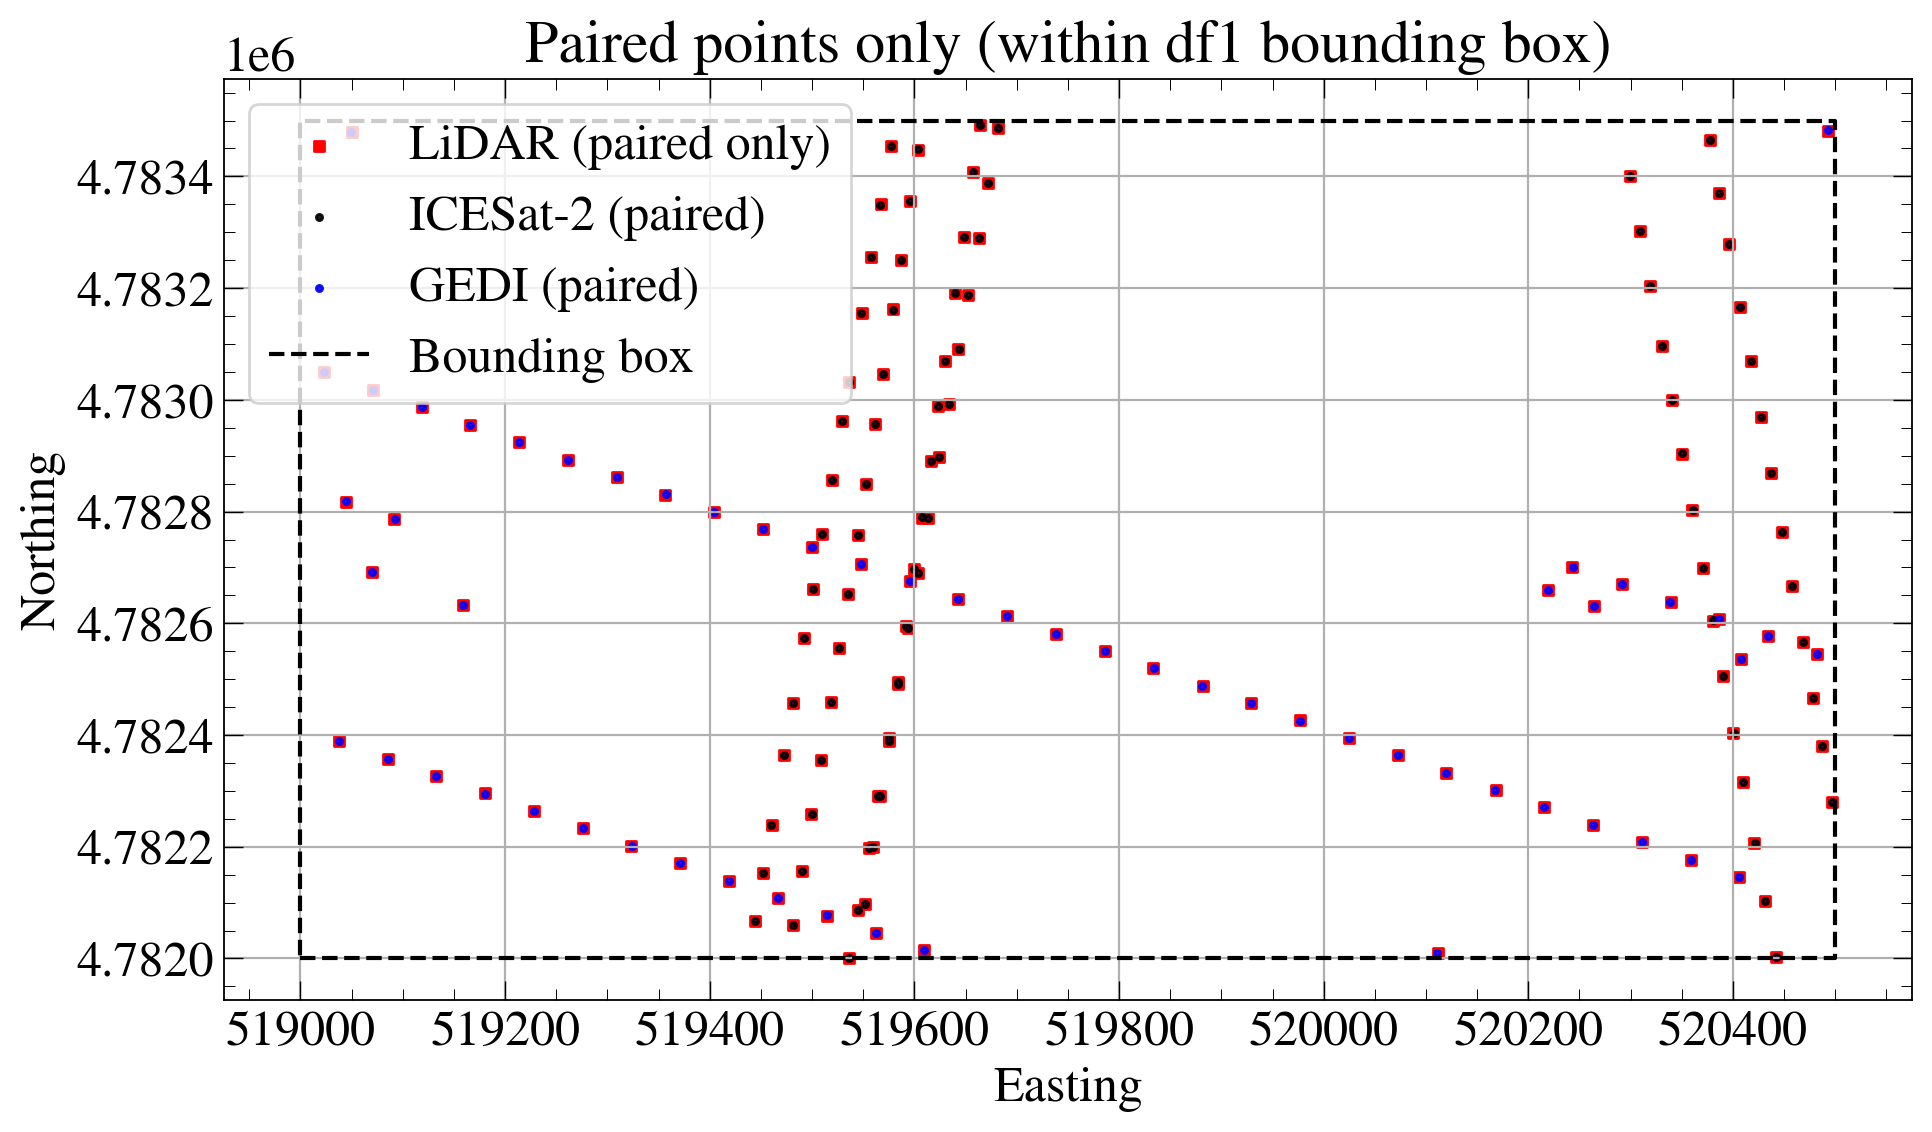

In [22]:
pairs_icesat2, pairs_gedi = pair_and_plot_indttest(
    data_airbone_lidar_ground, icesat2_gdf_atl08_ground, gedi_data_ground,
    xcol="Easting", ycol="Northing", elev_col="Elevation",
    max_dist=max_dist, plot=True, connect_pairs=True,
    equal_var=equal_var   # Welch by default; set True for Student's pooled t-test
)


### Independent T-Test: Non-Ground Points

In [23]:
pairs_icesat2, pairs_gedi = pair_and_plot_indttest(
    data_airbone_lidar_non_ground, icesat2_gdf_atl08_non_ground, gedi_data_non_ground,
    xcol="Easting", ycol="Northing", elev_col="Elevation",
    max_dist=max_dist, plot=False, connect_pairs=True,
    equal_var=equal_var   # Welch by default; set True for Student's pooled t-test
)



Independent t-test [df1 vs df2] on 'Elevation' — Student (equal variances)
  n1 = 3, n2 = 3, dof = 4
  mean(df1) = 1216.43, mean(dfX) = 1216.32
  difference (df1 - dfX) = 0.10601
  t = 0.0110536, p = 0.99171
  95% CI (diff): [-26.5218, 26.7338]

Independent t-test [df1 vs df3] on 'Elevation' — Student (equal variances)
  n1 = 59, n2 = 59, dof = 116
  mean(df1) = 1221.25, mean(dfX) = 1225.54
  difference (df1 - dfX) = -4.29197
  t = -2.00597, p = 0.0471866
  95% CI (diff): [-8.52971, -0.0542213]


In [24]:
# alpha = 0.05  # Significance level

# print(f"T-statistic: {t_statistic}")
# print(f"P-value: {p_value}")

# if p_value < alpha:
#     print("Reject the null hypothesis: There is a significant difference between the means of the two groups.")
# else:
#     print("Fail to reject the null hypothesis: There is no significant difference between the means of the two groups.")

# The End!!!